In [1]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
sys.path.append('../../lib/python')

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

import numpy as np
import matplotlib.pyplot as plt
from PySpice.Unit import *
import unittest

from pathlib import Path
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath( 'main', 'main_04.cir' )
NETLIST = str( kicad_netlist_path )

In [2]:
## schema definitions

import SchemDraw as schemdraw
import SchemDraw.elements as elm

d = schemdraw.Drawing()
op = d.add(elm.Opamp)
d.add(elm.Line(xy=op.out, l=.75, rgtlabel='$v_{out}$'))

d.add(elm.Line('left', xy=op.in1, l=.75))
d.add(elm.Line('up', l=1.5))
d.add(elm.Dot)
R1 = d.add(elm.Resistor('left', label='$R_1$'))
R5 = d.add(elm.Resistor('down', label='$R_5$', rotation=90, rotation_mode='default'))
d.add(elm.Dot)
d.add(elm.Resistor('down', label='$R_6$', rotation=90, rotation_mode='default'))
d.add(elm.Ground)

l = d.add(elm.Line('left', xy=R1.end, l=1.5))
d.add(elm.Line('left', l=.5, lftlabel='$v_{in}$'))
d.add(elm.Line('down', xy=l.end, l=1.5))
POT = d.add(elm.Potentiometer('down'))
POT.add_label('$RV_{(R3/R4)}$', loc='center', ofst=[0,-1], align=('right','bottom'))
d.add(elm.Ground,xy=POT.end)
d.add(elm.Line('right', xy=POT.tap, tox=R5.end))
d.add(elm.Line('right', xy=POT.tap, tox=op.in2-.75))
d.add(elm.Line('up', l=0.5))
d.add(elm.Line('right', l=.75))
Rf = d.add(elm.Resistor('right', xy=R1.start, tox=op.out+.5, label='$R_2$'))
d.add(elm.Line('down', toy=op.out))
end = d.add(elm.Dot)



In [3]:
from sympy import symbols, sqrt, exp, diff, integrate, pprint, latex, simplify, Eq                                                                                                                      
R1, R2, R3, R4, Vin, Vout = symbols('R1 R2 R3 R4 Vin Vout', real=True)
eq_diff = (1+R2/R1) * (R4/(R4+R3)) * Vin - (R2/R1) * Vin 
eq_paralell_resistor =  1 /( (1/R1) + (1/R2) ) 

![module](https://img.shields.io/badge/module-mischer-yellow)
![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

# *kontrast*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

## *table of contents*

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)

<br/><br/>

## *about*

kontrast ist a simple mixer utility module. it can be used as a **mixer**, **attenuator** or **attenuverter** for ac or dc signals. the function depends on the patching and settings of the potentiometers. an attenuverter is used in different modules like the  Serge VCS, Maths and also in the polivoks filter. while this module can be used as a simple mixer you can also adjust cv signals. such a signal can be simply attenuated or inverted. when feeding in a positive singal slope (for example from an adsr). the signal will be turned to a neagative dc singal. if the inpout signal is ac coupled the signal will be inverted. the function is the setting on the potentiometer of the channel. when the potentiometer is at center position. the output signal is attenuated to zero. no output singal is present. when turning to the right. the signal will be stronger until the output signal is equal to the input signal. when turning the potentiomenter to the left, the output signal will be phase shifted by 180°. when you turn the potentiometer to full left the output signal will be the inverted input signal. all the inputs are mixed to the output signal; unless you connect the output of a channel. then this output does not accure on the mixed signal.

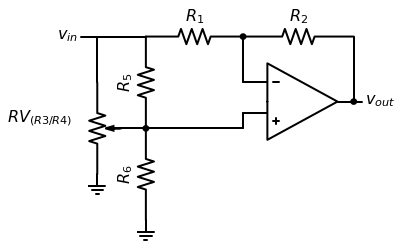

In [4]:
d.draw()

the circuit of the attenuverter is based on the opamp dfferential amplifer. the two resistors at the non-inverting inputs are replaced with a potentiometer. the potentiometer is configured as a voltage divider and replace R3 and R4 from the differential amplifier. when the position of the potentiometer is adjusted, the output voltage will change or invert. at the center position  the output is zero volrs. the response to the potentiometer is linear. we can make it an centered s-curve by adding two parallel resistors (R5,R6) to the potentiometer [[1][1]].

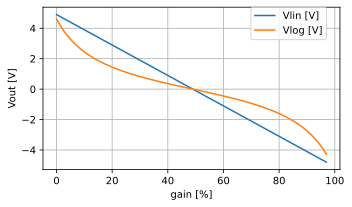

In [5]:
Vlin = []
Vlog = []

for Rtemp in np.arange(1@u_kOhm, 99@u_kOhm, 1@u_kOhm):
    R3t = Rtemp
    R4t = 100@u_kOhm - Rtemp
    Vtemp = eq_diff.subs(R1, 100000).subs(R2, 100000).subs(R3, R3t).subs(R4, R4t).subs(Vin, 5)    
    Vlin.append(Vtemp)

for Rtemp in np.arange(1@u_kOhm, 99@u_kOhm, 1@u_kOhm):
    R3t =  eq_paralell_resistor.subs(R1, Rtemp).subs(R2, 33000)
    R4t = eq_paralell_resistor.subs(R1, 100@u_kOhm - Rtemp).subs(R2, 33000) 
    Vtemp = eq_diff.subs(R1, 100000).subs(R2, 100000).subs(R3, R3t).subs(R4, R4t).subs(Vin, 5)    
    Vlog.append(Vtemp)

figure, ax = plt.subplots(figsize=(5, 3))
ax.plot(Vlin)  # the pot position from 0 .. 1
ax.plot(Vlog)  # the pot position from 0 .. 1
ax.legend(('Vlin [V]', 'Vlog [V]'), loc=(.7, .8))
ax.grid()
ax.set_xlabel('gain [%]')
ax.set_ylabel('Vout [V]')

plt.tight_layout()
plt.show()

the rest of the circuit is straight forwarn an opamp mixer at the output followed by an inverting amplifier with a gain of 1.

## construction

In [8]:
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Unit import *

class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3')
    def __init__(self, R1=1@u_Ω, R2=2@u_Ω):
        super().__init__()
        self.R(1, 'n1', 'n2', R1)
        self.R(2, 'n2', 'n3', R2)

circuit = Circuit('Test')
circuit.V('1', '+15V', circuit.gnd, 15@u_V)

circuit.subcircuit(VoltageDivider(R1=50@u_kΩ, R2=50@u_kΩ))
circuit.X('1', 'voltage_divider', '+15V', 'OUT', circuit.gnd)

print(circuit)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)

analysis = simulator.operating_point()
for node in (analysis['+15V'], analysis['OUT']): # .in is invalid !
    print('Node {}: {} V'.format(str(node), float(node)))



.title Test
.subckt voltage_divider n1 n2 n3
R1 n1 n2 50kOhm
R2 n2 n3 50kOhm
.ends voltage_divider
V1 +15V 0 15V
X1 +15V OUT 0 voltage_divider

Node +15v: 15.0 V
Node out: 7.5 V


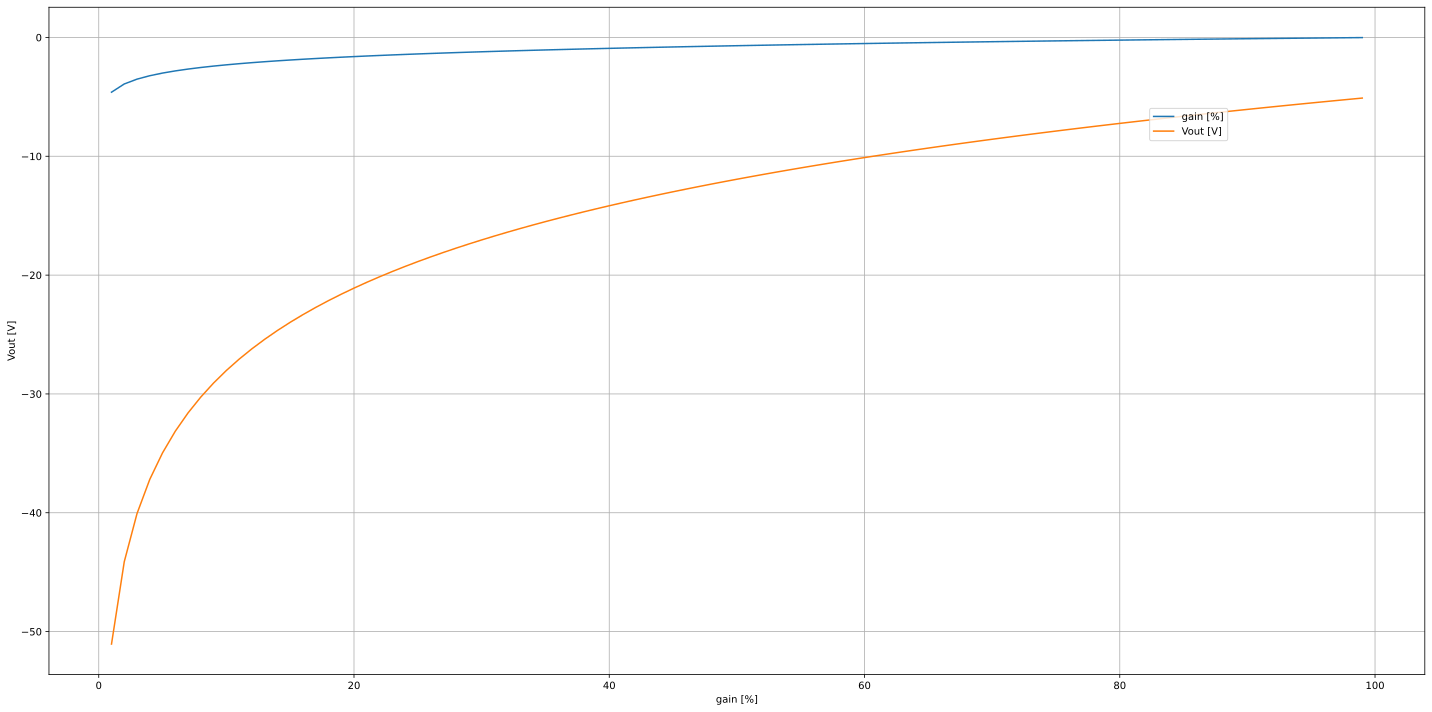

In [9]:



def calc_attenuvert( v ):
    print ( v )
    2 * v * 5 - 5

vin = 5
gain = np.arange(start=0, stop=1, step=0.01)
gain = np.log( gain )
attenuverter = lambda p: (2 * p * vin) - vin
v = np.array([attenuverter(xp) for xp in gain])


figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(gain)  # the pot position from 0 .. 1
ax.plot(v)  # the output voltage
ax.legend(('gain [%]', 'Vout [V]'), loc=(.8, .8))
ax.grid()
ax.set_xlabel('gain [%]')
ax.set_ylabel('Vout [V]')

plt.tight_layout()
plt.show()


## *construction*


the center building block of the attenuverter is an integrator opamp circuit. 







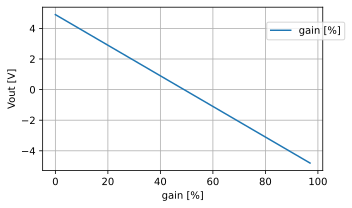

In [10]:
R1 = 100@u_kOhm
R2 = 100@u_kOhm
R3 = 90@u_kOhm
R4 = 10@u_kOhm
Vin = 5@u_V

Vsweep = []
for Rtemp in np.arange(1@u_kOhm, 99@u_kOhm, 1@u_kOhm):
    R3t = Rtemp
    R4t = 100@u_kOhm - Rtemp
    Vsweep.append( ( 1 + R2 / R1 ) * ( R4t / ( R3t + R4t ) )  * Vin - ( R2 / R1 ) * Vin )

figure, ax = plt.subplots(figsize=(5, 3))
ax.plot(Vsweep)  # the pot position from 0 .. 1
ax.legend(('gain [%]', 'Vout [V]'), loc=(.8, .8))
ax.grid()
ax.set_xlabel('gain [%]')
ax.set_ylabel('Vout [V]')

plt.tight_layout()
plt.show()





In [11]:


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice", "transistor")
spice_library = SpiceLibrary(spice_libraries_path)

class XU1(SubCircuitFactory):
    __name__ = 'XU1'
    __nodes__ = ( 'OUT', 'INVERTING', 'NON_INVERTING', 'POWER_NEGATIVE', 'POWER_POSITIVE' )
    def __init__(self):
        super().__init__()
        self.X('1', 'OPA2134', 'NON_INVERTING', 'INVERTING', 'POWER_POSITIVE', 'POWER_NEGATIVE', 'OUT' )

class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

# show the netlist
parser = SpiceParser(path=NETLIST)
circuit = parser.build_circuit(ground='GND')
circuit.include(spice_library['OPA2134'])
circuit.V('1', '+15V', circuit.gnd, 15@u_V)
circuit.V('2', '-15V', circuit.gnd, -15@u_V)

for subcircuit in ( XU1(), VoltageDivider(R=100@u_kOhm,w=0) ):
    circuit.subcircuit(subcircuit)

print(str(circuit))


NameError: name 'SpiceLibrary' is not defined

In [12]:
steps = np.arange( 0, 1, 0.01 )
results = []

for s in steps:

    parser = SpiceParser(path=NETLIST)
    circuit = parser.build_circuit(ground='GND')
    circuit.include(spice_library['OPA2134'])
    circuit.V('1', '+15V', circuit.gnd, 15@u_V)
    circuit.V('2', '-15V', circuit.gnd, -15@u_V)

    for subcircuit in ( XU1(), VoltageDivider(R=100@u_kOhm,w=s) ):
        circuit.subcircuit(subcircuit)


    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()

    results.append( float( analysis['Net-_J2-PadT_'] ) )

figure, ax = plt.subplots(figsize=(10, 5))
ax.plot(results)  # input
ax.legend(('Vin [V]', 'Vout [V]', 'Vdiv [V]'), loc=(.1, .8))
ax.grid()
ax.set_xlabel('wiper [%]')
ax.set_ylabel('[V]')

plt.tight_layout()
plt.show()


NameError: name 'SpiceParser' is not defined

In [13]:
parser = SpiceParser(path=NETLIST)
circuit = parser.build_circuit(ground='GND')
circuit.include(spice_library['OPA2134'])
circuit.V('1', '+15V', circuit.gnd, 15@u_V)
circuit.V('2', '-15V', circuit.gnd, -15@u_V)

for subcircuit in ( XU1(), VoltageDivider(R=100@u_kOhm,w=0) ):
    circuit.subcircuit(subcircuit)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=20@u_us, end_time=10@u_ms)

figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(analysis['Net-_J1-PadT_'])  # input
ax.plot(analysis['/MIX_1'])  # input
#ax.plot(analysis['Net-_RV1-Pad2_'])  # voltage divider output
ax.legend(('Vin [V]', 'Vout [V]', 'Vdiv [V]'), loc=(.8, .8))
ax.grid()
ax.set_xlabel('t [s]')
ax.set_ylabel('[V]')

plt.tight_layout()
plt.show()

NameError: name 'SpiceParser' is not defined

the input voltage for the amplifier has to be around 100mV. We need to buffer the input signal and attenuate it to that level.

inverting opa amplifier:

\begin{align*}
Vout = -Vin * \left(\frac{R1}{R2}\right)
\end{align*}





## links


1) Rod Elliott (ESP) [Beginners' Guide to Potentiometers][2] 


---
[![CC BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)](https://creativecommons.org/licenses/by-sa/4.0/)


[1]: https://wikipedia.org
[2]: https://sound-au.com/pots.htm
